## WeGo Data Introduction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
purple = (0.459, 0.235, 0.745)
gray = (0.827, 0.827, 0.827)
black = (0.137, 0.122, 0.125)

In [3]:
wego = pd.read_csv("../data/headway_data.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [4]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

# create headway deviation percentable column
wego.loc[:, 'HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [5]:
# Create Bunching or Gapping Indicator
def is_hdwy_bunching(dev, pct):
    if (dev < 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_gapping(dev, pct):
    if (dev > 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_acceptable(pct):
    if pct <= 50:
        return int(1)
    else:
        return int(0)

In [6]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,6.500000,NaN,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,0.000000,NaN,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,0.000000,NaN,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,NaN,0,0.000000,NaN,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,0,0,1,0,0.0,0,12.866666,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,5.266666,0,1,0,0,0.0,0,0.000000,NaN,17.555553
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,0,1,0,0,NaN,0,0.000000,NaN,NaN
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,1.866666,0,0,1,0,0.0,0,0.000000,NaN,6.222220
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,17.500000,0,1,0,0,0.0,0,0.000000,NaN,58.333333


In [7]:
wego.loc[:, 'HDWY_BUNCHING'] = wego.apply(lambda r: 
                                          is_hdwy_bunching(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_ACCEPTABLE'] = wego.apply(lambda r: 
                                            is_hdwy_acceptable(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_GAPPING'] = wego.apply(lambda r: 
                                         is_hdwy_gapping(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)

In [8]:
wego.HDWY_BUNCHING.sum()

17999

In [9]:
wego.HDWY_ACCEPTABLE.sum()

225918

In [10]:
wego.HDWY_GAPPING.sum()

21930

In [11]:
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

def hdw_gapping(pct):
    if (pct > 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)
    
def hdw_acceptable(pct):
    if abs(pct) <= 50:
        return int(1)
    else:
        return int(0)
    
def hdw_bunching(pct):
    if (pct > 0) & (abs(pct) < 50):
        return int(1)
    else:
        return int(0)

wego.loc[:, 'HDWY_BUNCHING'] = wego.apply(lambda r: hdw_bunching(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_ACCEPTABLE'] = wego.apply(lambda r: hdw_acceptable(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_GAPPING'] = wego.apply(lambda r: hdw_gapping(r['HDWY_DEV_PCT']), axis=1)

In [12]:
wego['HDWY_DEV'].info(verbose = True)

<class 'pandas.core.series.Series'>
RangeIndex: 350329 entries, 0 to 350328
Series name: HDWY_DEV
Non-Null Count   Dtype  
--------------   -----  
265893 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


In [13]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_BUNCHING',
       'HDWY_ACCEPTABLE', 'HDWY_GAPPING'],
      dtype='object')

In the data, the bus route can be identified by its ROUTE_ABBR value.  
**3:** West End  
**7:** Hillsboro  
**22:** Bordeaux  
**23:** Dickerson Pike  
**50:** Charlotte Pike  
**52:** Nolensville Pike  
**55:** Murfreesboro Pike  
**56:** Gallatin Pike

In [14]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25959
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

The trip can be identified by the DATE/CALENDAR_ID plus the TRIP_ID.  
**Warning:** The TRIP_ID refers to the route and time but will be used across multiple days.

The data contains multiple **time points** for each trip. There are more stops along the route than time points, but the time points are the points with specific scheduled times the bus operators must adhere to.

The first stop of a trip has a TRIP_EDGE of 1, the last has a TRIP_EDGE of 2, and the intermediate stops are TRIP_EDGE 0. 

Here is the first trip in the dataset. It was a Bordeaux route (Route 22), scheduled to start at 4:42:00 and end at 5:10:00.

In [15]:
wego[['DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']].loc[:3]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,2023-08-01,120230801,345104,22,MHSP,1,2023-08-01 04:42:00
1,2023-08-01,120230801,345104,22,ELIZ,0,2023-08-01 04:46:00
2,2023-08-01,120230801,345104,22,CV23,0,2023-08-01 04:54:00
3,2023-08-01,120230801,345104,22,MCC5_10,2,2023-08-01 05:10:00


Note that the same TRIP_ID appears on the following day.

In [16]:
(
    wego
    .loc[wego['DATE'].astype(str).isin(['2023-08-01', '2023-08-02'])]
    .loc[wego['TRIP_ID'] == 345104]
    [['DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'ROUTE_DIRECTION_NAME', 'SCHEDULED_TIME', 'ROUTE_STOP_SEQUENCE']]
)

,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,TRIP_EDGE,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,ROUTE_STOP_SEQUENCE
0,2023-08-01,22,345104,MHSP,1,TO DOWNTOWN,2023-08-01 04:42:00,14.0
1,2023-08-01,22,345104,ELIZ,0,TO DOWNTOWN,2023-08-01 04:46:00,10.0
2,2023-08-01,22,345104,CV23,0,TO DOWNTOWN,2023-08-01 04:54:00,5.0
3,2023-08-01,22,345104,MCC5_10,2,TO DOWNTOWN,2023-08-01 05:10:00,1.0
6461,2023-08-02,22,345104,MHSP,1,TO DOWNTOWN,2023-08-02 04:42:00,14.0
6462,2023-08-02,22,345104,ELIZ,0,TO DOWNTOWN,2023-08-02 04:46:00,10.0
6463,2023-08-02,22,345104,CV23,0,TO DOWNTOWN,2023-08-02 04:54:00,5.0
6464,2023-08-02,22,345104,MCC5_10,2,TO DOWNTOWN,2023-08-02 05:10:00,1.0


**Adherence** refers to the difference between scheduled time and the actual time that the bus departs from a stop.

A negative value for ADHERENCE indicates that the bus is late, and a positive indicates that the bus is early.

Generally, an adherence value less than -6 is considered late, and greater than 1 is considered early, but there are some exceptions. For example, a positive adherence for the end of a trip (TRIP_EDGE 2) is not considered early, since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. You can check whether a trip was considered on-time, early, or late using the ADJUSTED_EARLY_COUNT, ADJUSTED_LATE_COUNT, and ADJUSTED_ONTIME_COUNT columns.

Here is an example of a trip where all time points would be considered to be on time. Notice that at the end of the trip, the bus was more than 6 minutes early, but was still counted as on-time since this was a trip edge of 2.

In [17]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[:3]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,2023-08-01,120230801,345104,22,MHSP,1,2023-08-01 04:42:00,2023-08-01 04:44:08,-2.133333,0,0,1
1,2023-08-01,120230801,345104,22,ELIZ,0,2023-08-01 04:46:00,2023-08-01 04:48:27,-2.450000,0,0,1
2,2023-08-01,120230801,345104,22,CV23,0,2023-08-01 04:54:00,2023-08-01 04:54:56,-0.933333,0,0,1
3,2023-08-01,120230801,345104,22,MCC5_10,2,2023-08-01 05:10:00,2023-08-01 05:03:43,6.283333,0,0,1


And one that has one late stop.

In [18]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[77:79]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
77,2023-08-01,120230801,345127,22,MHSP,1,2023-08-01 17:05:00,2023-08-01 17:08:21,-3.350000,0,0,1
78,2023-08-01,120230801,345127,22,CV23,0,2023-08-01 17:14:00,2023-08-01 17:20:10,-6.166666,0,1,0
79,2023-08-01,120230801,345127,22,MCC5_10,2,2023-08-01 17:30:00,2023-08-01 17:30:23,-0.383333,0,0,1


And one which was early.

In [19]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[11:13]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
11,2023-08-01,120230801,345107,22,MCC5_10,1,2023-08-01 06:15:00,2023-08-01 06:16:19,-1.316666,0,0,1
12,2023-08-01,120230801,345107,22,CV23,0,2023-08-01 06:25:00,2023-08-01 06:23:30,1.500000,1,0,0
13,2023-08-01,120230801,345107,22,MHSP,2,2023-08-01 06:35:00,2023-08-01 06:30:59,4.016666,0,0,1


**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 

The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

In [20]:
(
    wego
    .loc[wego['ROUTE_ABBR'] == 22]
    .loc[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']
    .loc[wego['TIME_POINT_ABBR'] == 'CV23']
    [['DATE', 'TRIP_ID', 'TIME_POINT_ABBR','ROUTE_DIRECTION_NAME', 'TRIP_EDGE', 
      'SCHEDULED_TIME', 'SCHEDULED_HDWY',
      'ACTUAL_DEPARTURE_TIME', 'ACTUAL_HDWY', 'HDWY_DEV'
     ]]
    .sort_values(['DATE', 'SCHEDULED_TIME'])
    .iloc[:5]
)

,DATE,TRIP_ID,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,TRIP_EDGE,SCHEDULED_TIME,SCHEDULED_HDWY,ACTUAL_DEPARTURE_TIME,ACTUAL_HDWY,HDWY_DEV
2,2023-08-01,345104,CV23,TO DOWNTOWN,0,2023-08-01 04:54:00,NaN,2023-08-01 04:54:56,NaN,NaN
126,2023-08-01,345213,CV23,TO DOWNTOWN,0,2023-08-01 05:19:00,25.0,2023-08-01 05:18:59,24.050000,-0.950000
402,2023-08-01,345405,CV23,TO DOWNTOWN,0,2023-08-01 05:39:00,20.0,2023-08-01 05:39:40,20.683333,0.683333
9,2023-08-01,345106,CV23,TO DOWNTOWN,0,2023-08-01 05:54:00,15.0,2023-08-01 05:54:11,14.516666,-0.483334
316,2023-08-01,345377,CV23,TO DOWNTOWN,0,2023-08-01 06:09:00,15.0,2023-08-01 06:10:01,15.833333,0.833333


Two other columns that you've been asked to explore are the DWELL_IN_MINS column and SCHEDULED_LAYOVER_MINUTES, which shows the difference between actual arrival and actual departure time at a time point and the time a bus was scheduled to arrive at the time point and when it is scheduled to leave at the beginning of a trip.

Here, we can see the end of the first trip in the dataset and the beginning of the next trip, which goes in the opposite direction.

In [21]:
wego.loc[3:4, ['DATE', 'TRIP_ID', 'TRIP_EDGE', 'TIME_POINT_ABBR',
               'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES']]

,DATE,TRIP_ID,TRIP_EDGE,TIME_POINT_ABBR,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
3,2023-08-01,345104,2,MCC5_10,2023-08-01 05:03:43,2023-08-01 05:03:43,0.000000,NaN
4,2023-08-01,345105,1,MCC5_10,2023-08-01 05:03:43,2023-08-01 05:16:35,12.866666,5.0


In [22]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_BUNCHING',
       'HDWY_ACCEPTABLE', 'HDWY_GAPPING'],
      dtype='object')

In [23]:
cutoff= (-100,-6,1,100)
labels=['late', 'on_time', 'early']
wego['LATE_EARLY'] = pd.cut(wego['ADHERENCE'], bins = cutoff, labels=labels)
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,LATE_EARLY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,6.500000,NaN,NaN,0,0,0,on_time
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,NaN,0,0,0,on_time
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,NaN,0,0,0,on_time
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,NaN,0,0.000000,NaN,NaN,0,0,0,early
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,0.0,0,12.866666,5.0,NaN,0,0,0,on_time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,17.555553,0,1,0,late
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,NaN,0,0.000000,NaN,NaN,0,0,0,late
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0,0.0,0,0.000000,NaN,6.222220,0,1,0,on_time
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0,0.0,0,0.000000,NaN,58.333333,0,0,1,late


## Question 1: What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [24]:
round(wego['ADJUSTED_ONTIME_COUNT'].value_counts()[1] / wego.shape[0] * 100,2)

77.08

### 77% of checkins here considered on time


In [25]:
wego[['ADHERENCE']].apply(['min','max','mean'])

,ADHERENCE
min,-948.533333
max,88.383333
mean,-3.188796


In [26]:
adherence_std = np.std(wego[['ADHERENCE']])
adherence_mean = wego[['ADHERENCE']].mean()

In [27]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_BUNCHING',
       'HDWY_ACCEPTABLE', 'HDWY_GAPPING', 'LATE_EARLY'],
      dtype='object')

## Question 2: How does direction of travel, route, or location affect the headway and on-time performance?

In [28]:
to_downtown = wego[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']

In [29]:
from_downtown = wego[wego['ROUTE_DIRECTION_NAME'] == 'FROM DOWNTOWN']

In [30]:
to_downtown['HDWY_DEV'].mean()

0.4477730454373861

In [31]:
from_downtown['HDWY_DEV'].mean()

0.579990048857078

### Slighly higher headway deviation going from downtown then towards

In [32]:
to_downtown['ADHERENCE'].mean()

-2.3218044230829493

In [33]:
from_downtown['ADHERENCE'].mean()

-3.960287122712012

### From downtown and to downtown are both 'on time' using the required criteria. BUT towards downtown is slightly faster  

In [34]:
wego[wego['ROUTE_DIRECTION_NAME']=='FROM DOWNTOWN']['ADHERENCE'].apply(['min','max','mean','median'])

min      -948.533333
max        76.766666
mean       -3.960287
median     -2.516666
Name: ADHERENCE, dtype: float64

In [35]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].describe()

ADHERENCE                                                      \
               count      mean       std         min       25%       50%   
ROUTE_ABBR                                                                 
3            45488.0 -3.761491  5.415910 -133.250000 -5.350000 -2.566666   
7            17267.0 -3.346555  6.669753  -87.716666 -4.916666 -2.116666   
22           25188.0 -1.138107  6.391798 -675.000000 -2.950000 -0.933333   
23           39653.0 -1.760110  7.680491 -618.166666 -3.116666 -1.316666   
50           42629.0 -2.505022  6.159666 -489.316666 -3.883333 -1.800000   
52           49327.0 -3.971342  8.721732 -948.533333 -5.016666 -2.066666   
55           60359.0 -4.823302  7.535092 -375.233333 -6.583333 -2.883333   
56           58950.0 -2.703988  4.931009 -322.783333 -4.300000 -1.900000   

                                HDWY_DEV                                  \
                 75%        max    count      mean        std        min   
ROUTE_ABBR                                                                 
3          -0.766666  33.750000  36583.0  0.580907   6.203530 -64.000000   
7          -0.616666  88.383333  11578.0  0.336808   5.909983 -30.433334   
22          0.816666  24.733333  17007.0  0.955867  10.248444 -43.650000   
23          0.033333  33.633333  28478.0  1.053563   9.881327 -32.116667   
50         -0.300000  22.350000  34593.0  0.212376   4.760558 -33.250000   
52         -0.400000  30.200000  39887.0  0.974776   9.185015 -55.533334   
55         -0.850000  40.250000  49432.0  0.261038   6.364978 -29.933334   
56         -0.283333  39.916666  48335.0  0.149213   4.714435 -27.266667   

                                                      
                 25%       50%       75%         max  
ROUTE_ABBR                                            
3          -2.450000  0.116666  2.800000   76.866666  
7          -1.983334  0.033333  2.133333   50.250000  
22         -1.966667  0.050000  2.200000  508.700000  
23         -1.733334  0.066666  2.066666  565.433333  
50         -2.083334  0.033333  2.183333   54.283333  
52         -2.450000  0.083333  2.783333  472.366666  
55         -3.150000 -0.033334  2.983333  102.000000  
56         -2.333334  0.000000  2.383333  166.000000

In [36]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Route 22 has better over all Adherence while route 56 has a better headway deviation

In [37]:
wego.groupby('BLOCK_ABBR')[['ADHERENCE','HDWY_DEV']].mean().abs().sort_values('ADHERENCE', ascending = True)


,ADHERENCE,HDWY_DEV
BLOCK_ABBR,,
8604,0.281250,1.238889
2301,0.353140,0.263938
2210,0.442440,0.874254
2211,0.529404,0.778633
8401,0.603704,NaN
...,...,...
5218,7.901945,3.985199
5513,8.414195,0.912638
5590,9.226351,NaN


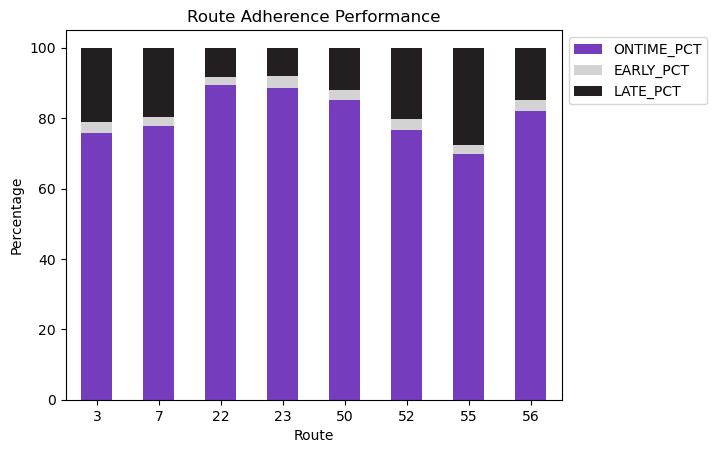

In [38]:
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True, color=[purple,gray,black])
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

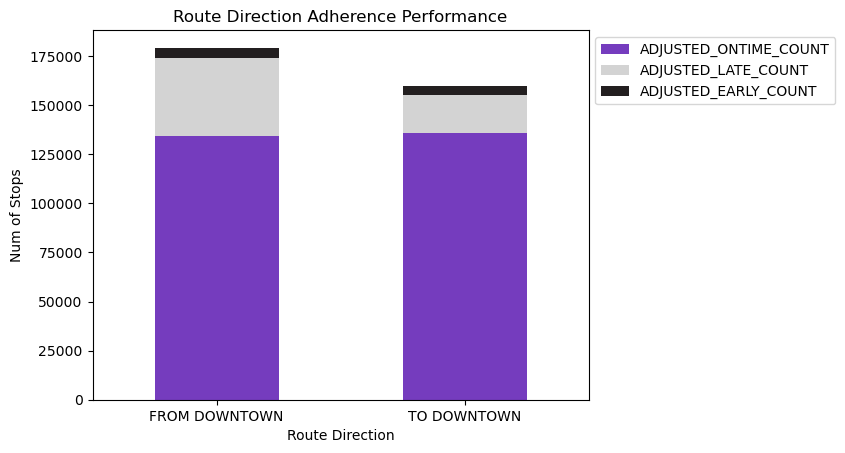

In [39]:
ax = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Route Direction Adherence Performance',
        xlabel = 'Route Direction',
       ylabel = 'Num of Stops')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

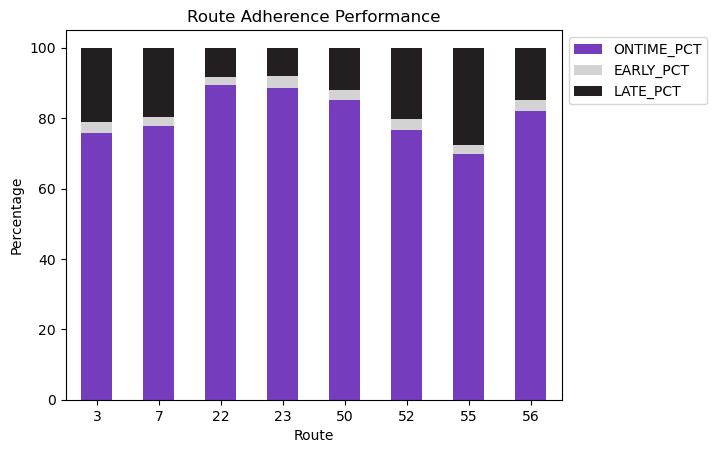

In [40]:
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

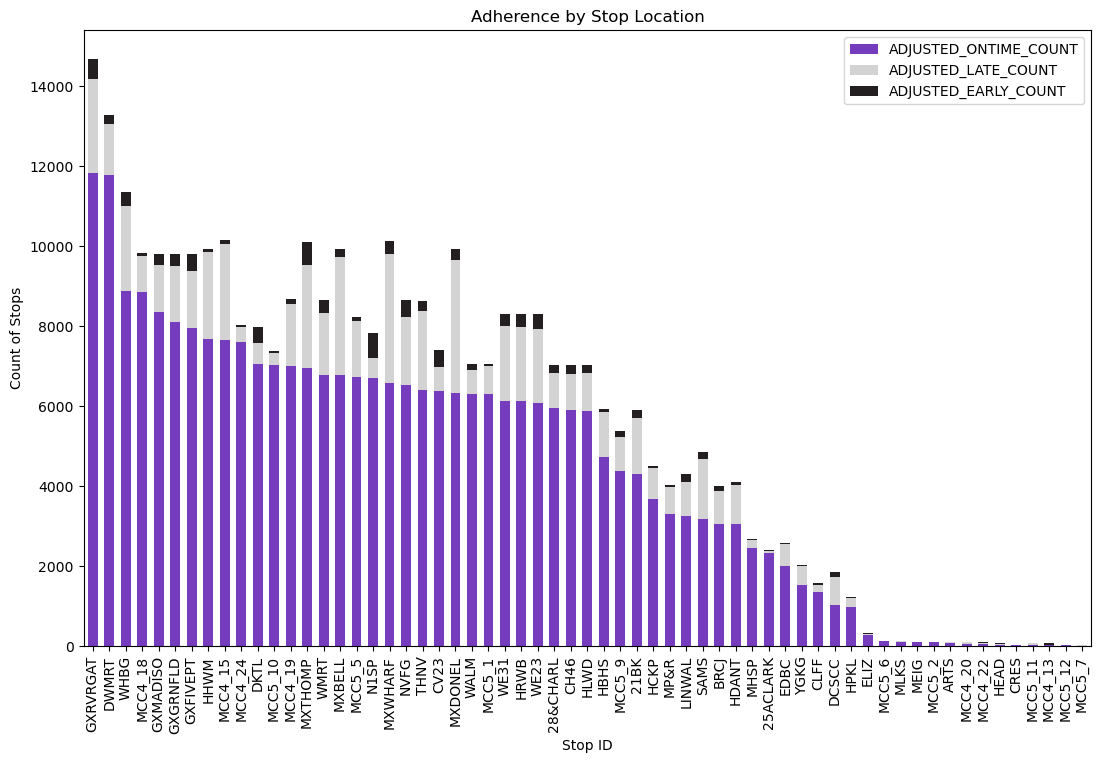

In [41]:
loc_adh_chart = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True, color=[purple,gray,black], width=0.6, figsize=(13,8))
loc_adh_chart.set(title='Adherence by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
loc_adh_chart.legend(bbox_to_anchor=(1, 1))

In [42]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending = True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,-37.570714,NaN
MCC4_20,-13.356229,NaN
MCC5_12,-9.785042,NaN
MCC5_7,-9.075463,NaN
DCSCC,-7.091481,12.054055
...,...,...
HEAD,1.013657,NaN
MCC5_2,1.252623,NaN
25ACLARK,1.458553,0.551163


In [43]:
routes_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT
ROUTE_ABBR,,,,,,,
3,34516,9590,1382,45488,75.879353,3.038164,21.082483
7,13417,3417,433,17267,77.703133,2.507674,19.789193
22,22492,2065,631,25188,89.296490,2.505161,8.198348
23,35137,3230,1286,39653,88.611202,3.243134,8.145664
50,36309,5113,1207,42629,85.174412,2.831406,11.994182
52,37736,10038,1553,49327,76.501713,3.148377,20.349910
55,42080,16748,1531,60359,69.716198,2.536490,27.747312
56,48361,8837,1752,58950,82.037320,2.972010,14.990670


## Question 3: How does time of day or day of week affect headway and on-time performance?

In [44]:
### Changed Date column to datetime
wego['DATE'] = pd.to_datetime(wego['DATE'])

In [45]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,LATE_EARLY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,6.500000,NaN,NaN,0,0,0,on_time
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,NaN,0,0,0,on_time
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,NaN,0,0,0,on_time
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,NaN,0,0.000000,NaN,NaN,0,0,0,early
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,0.0,0,12.866666,5.0,NaN,0,0,0,on_time


In [46]:
wego['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday

In [47]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday

C:\Users\asus\AppData\Local\Temp\ipykernel_15932\2490818292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday


In [48]:
wego['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                         format='mixed').dt.hour)

In [49]:
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                         format='mixed').dt.hour)

C:\Users\asus\AppData\Local\Temp\ipykernel_15932\293309290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],


In [50]:
### Shows the Hourly ADH and headway (NA values excluded)
adherence_by_hour = clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean()
adherence_by_hour

,ADHERENCE,HDWY_DEV
HOUR,,
0,-4.478019,0.905051
1,-10.618182,4.021621
4,-0.785533,-0.771043
5,-0.966710,0.306431
6,-1.501108,0.347326
7,-2.691298,0.700018
8,-3.758128,0.413859
9,-2.611876,0.265547
10,-2.117932,0.314521


<Axes: xlabel='HOUR'>

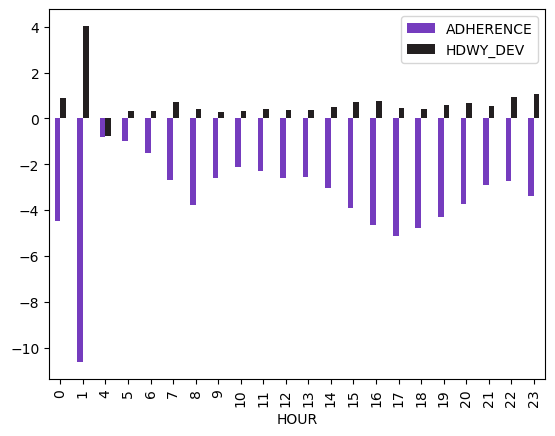

In [51]:
clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean().plot(kind='bar', color=[purple,black])


In [52]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
        [['ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_EARLY_COUNT']].sum())

In [53]:
hour_totals['TOTALS'] = hour_totals.sum(axis=1)

In [54]:
hour_totals.loc[:, 'ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

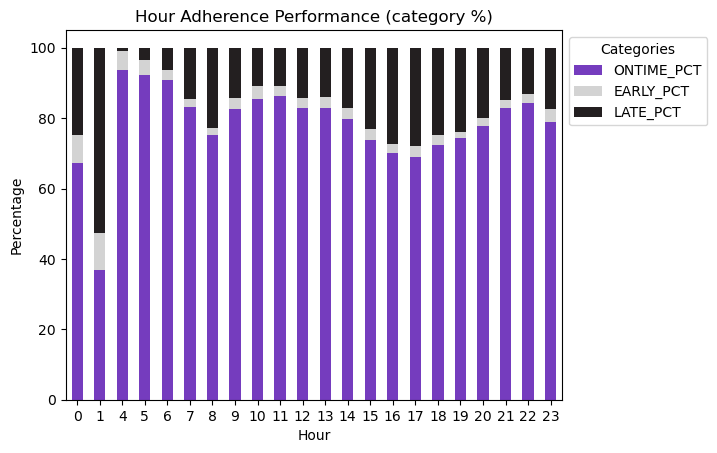

In [55]:
ax = (hour_totals[['ONTIME_PCT','EARLY_PCT','LATE_PCT']]).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Hour Adherence Performance (category %)',
            xlabel = 'Hour',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.tick_params(axis='x', rotation=0)

In [56]:
clean_dept_time

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,WEEKDAY,HOUR
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0.0,0,6.500000,NaN,NaN,0,0,0,1,4
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,NaN,0,0,0,1,4
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,NaN,0,0,0,1,4
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0.000000,NaN,NaN,0,0,0,1,5
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,0.0,0,12.866666,5.0,NaN,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,17.555553,0,1,0,5,22
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,0,0.000000,NaN,NaN,0,0,0,5,22
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0.0,0,0.000000,NaN,6.222220,0,1,0,5,22
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0.0,0,0.000000,NaN,58.333333,0,0,1,5,23


In [57]:
weekday_totals = (
    clean_dept_time.groupby('WEEKDAY')
        [['ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_EARLY_COUNT']].sum())

In [58]:
weekday_totals['TOTALS'] = weekday_totals.sum(axis=1)

In [59]:
weekday_totals.loc[:, 'ONTIME_PCT'] = weekday_totals['ADJUSTED_ONTIME_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'EARLY_PCT'] = weekday_totals['ADJUSTED_EARLY_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'LATE_PCT'] = weekday_totals['ADJUSTED_LATE_COUNT'] / weekday_totals['TOTALS'] * 100

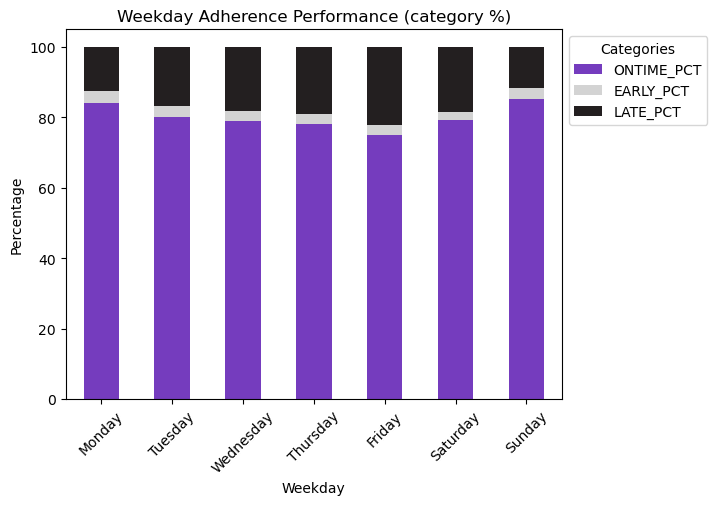

In [60]:
ax = (weekday_totals[['ONTIME_PCT','EARLY_PCT','LATE_PCT']]).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Weekday Adherence Performance (category %)',
            xlabel = 'Weekday',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

In [61]:
weekday_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT
WEEKDAY,,,,,,,
0,40319,6005,1665,47989,84.017171,3.469545,12.513284
1,45502,9587,1685,56774,80.145841,2.967908,16.886251
2,45009,10297,1635,56941,79.044976,2.871393,18.083630
3,44030,10667,1570,56267,78.251906,2.790268,18.957826
4,41973,12389,1552,55914,75.067067,2.775691,22.157241
5,28962,6747,821,36530,79.282781,2.247468,18.469751
6,24253,3346,847,28446,85.259790,2.977572,11.762638


In [62]:
clean_dept_time

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,WEEKDAY,HOUR
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0.0,0,6.500000,NaN,NaN,0,0,0,1,4
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,NaN,0,0,0,1,4
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,NaN,0,0,0,1,4
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0.000000,NaN,NaN,0,0,0,1,5
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,0.0,0,12.866666,5.0,NaN,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,17.555553,0,1,0,5,22
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,0,0.000000,NaN,NaN,0,0,0,5,22
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0.0,0,0.000000,NaN,6.222220,0,1,0,5,22
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0.0,0,0.000000,NaN,58.333333,0,0,1,5,23


In [63]:
hour_hdwy_totals = (
    clean_dept_time.groupby('HOUR')
        [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
        .sum()
)

In [64]:
hour_hdwy_totals['TOTALS'] = hour_hdwy_totals.sum(axis=1)

In [65]:
hour_hdwy_totals.loc[:, 'BUNCHING_PCT'] = hour_hdwy_totals['HDWY_BUNCHING'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = hour_hdwy_totals['HDWY_ACCEPTABLE'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'GAPPING_PCT'] = hour_hdwy_totals['HDWY_GAPPING'] / hour_hdwy_totals['TOTALS'] * 100

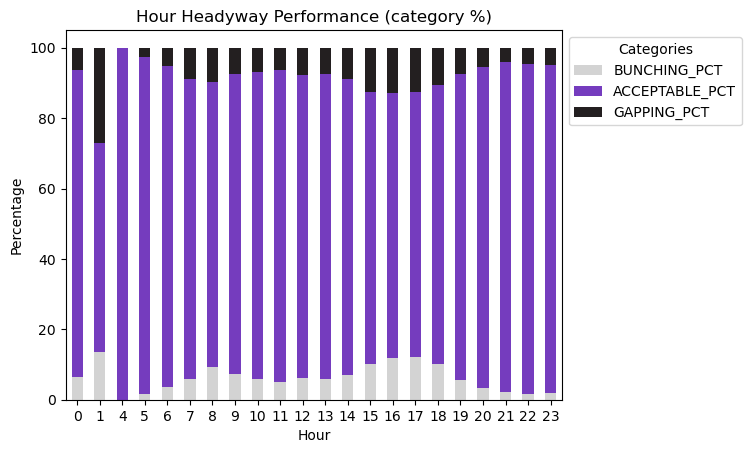

In [66]:
ax = (hour_hdwy_totals[['BUNCHING_PCT','ACCEPTABLE_PCT','GAPPING_PCT']]).plot(kind='bar', stacked=True,color=[gray,purple,black])
ax.set(title = 'Hour Headyway Performance (category %)',
            xlabel = 'Hour',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.tick_params(axis='x', rotation=0)

In [67]:
weekday_hdwy_totals = (
    clean_dept_time.groupby('WEEKDAY')
        [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
        .sum()
)

In [68]:
weekday_hdwy_totals['TOTALS'] = weekday_hdwy_totals.sum(axis=1)

In [69]:
weekday_hdwy_totals.loc[:, 'BUNCHING_PCT'] = weekday_hdwy_totals['HDWY_BUNCHING'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = weekday_hdwy_totals['HDWY_ACCEPTABLE'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'GAPPING_PCT'] = weekday_hdwy_totals['HDWY_GAPPING'] / weekday_hdwy_totals['TOTALS']

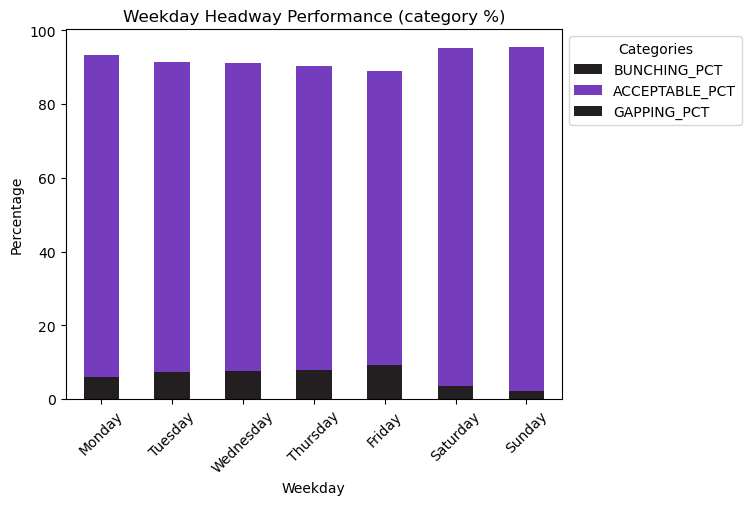

In [70]:
ax = (weekday_hdwy_totals[['BUNCHING_PCT','ACCEPTABLE_PCT','GAPPING_PCT']]).plot(kind='bar', stacked=True,color=[black, purple])
ax.set(title = 'Weekday Headway Performance (category %)',
            xlabel = 'Weekday',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

In [71]:
weekday_hdwy_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,TOTALS,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
WEEKDAY,,,,,,,
0,2241,32875,2573,37689,5.946032,87.227042,0.068269
1,3239,37530,3817,44586,7.264612,84.174405,0.085610
2,3444,37301,3949,44694,7.705732,83.458630,0.088356
3,3525,36404,4278,44207,7.973850,82.348949,0.096772
4,4028,35014,4901,43943,9.166420,79.680495,0.111531
5,1039,26108,1397,28544,3.639994,91.465807,0.048942
6,483,20686,1015,22184,2.177245,93.247386,0.045754


### The early time of day ie: 4am - 2pm have around the same adherence around -1 - -3 then spikes up to -4 and -5 until it starts dropping back down at 9pm. 1am is an outlire with an average of -10

### The headway deviation is all around the 0 mark except for a large outlire at 1am with a average headway of 4

In [72]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

C:\Users\asus\AppData\Local\Temp\ipykernel_15932\2176059727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday


In [73]:
### This is shows the ADH and Headway for weekdays starting at 0 which is monday
adherence_by_day = clean_dept_time.groupby('WEEKDAY')[['ADHERENCE', 'HDWY_DEV']].mean()
adherence_by_day

,ADHERENCE,HDWY_DEV
WEEKDAY,,
0,-2.434586,0.289773
1,-2.952484,0.401450
2,-3.264622,0.368556
3,-3.455171,0.524049
4,-3.792110,0.644195
5,-3.400493,0.633628
6,-2.808781,1.016830


In [74]:
wego.groupby('HOUR')[['HDWY_DEV','SCHEDULED_HDWY']].mean()

,HDWY_DEV,SCHEDULED_HDWY
HOUR,,
0.0,0.905051,32.144821
1.0,4.021621,44.594595
4.0,-0.771043,23.632184
5.0,0.306431,20.891133
6.0,0.347326,16.538616
7.0,0.700018,14.938857
8.0,0.413859,15.338848
9.0,0.265547,16.344796
10.0,0.314521,16.090257


In [75]:
wego[['HDWY_DEV_PCT','HDWY_BUNCHING','HDWY_ACCEPTABLE','HDWY_GAPPING']]

,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING
0,NaN,0,0,0
1,NaN,0,0,0
2,NaN,0,0,0
3,NaN,0,0,0
4,NaN,0,0,0
...,...,...,...,...
350324,17.555553,0,1,0
350325,NaN,0,0,0
350326,6.222220,0,1,0
350327,58.333333,0,0,1


### Question 4: How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

In [76]:
adherence_op = wego.groupby('OPERATOR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending = False)

In [77]:
adherence_op = adherence_op.dropna(subset = 'HDWY_DEV')

In [78]:
hdwy_op = wego.groupby('OPERATOR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('HDWY_DEV', ascending = False)

In [79]:
hdwy_op = hdwy_op.dropna(subset = 'HDWY_DEV')

In [80]:
adherence_op

,ADHERENCE,HDWY_DEV
OPERATOR,,
2646,2.395238,-3.360834
1761,1.297954,-1.628791
1762,1.168067,-1.957749
1606,1.124510,-2.316667
465,1.119445,-1.365556
...,...,...
1880,-9.765789,-1.662791
1016,-10.519806,1.461884
3101,-11.131714,3.596319


In [81]:
hdwy_op

,ADHERENCE,HDWY_DEV
OPERATOR,,
2432,0.080716,10.363275
2309,-8.619658,8.440625
2137,-9.382539,6.230208
1596,-5.739583,5.564166
3165,-7.501562,5.553472
...,...,...
2675,0.252713,-2.629115
2646,2.395238,-3.360834
2493,-1.050926,-3.862963


In [82]:
operator_totals = (
    wego.groupby('OPERATOR')
        [['ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT',
          'ADJUSTED_EARLY_COUNT','HDWY_BUNCHING',
          'HDWY_ACCEPTABLE','HDWY_GAPPING']]
          .sum()
)

In [83]:
operator_totals['ADH_TOTALS'] = (operator_totals[['ADJUSTED_ONTIME_COUNT',
                                             'ADJUSTED_LATE_COUNT',
                                             'ADJUSTED_EARLY_COUNT']].sum(axis=1))

In [84]:
operator_totals['HDWY_TOTALS'] = (operator_totals[['HDWY_BUNCHING',
                                             'HDWY_ACCEPTABLE',
                                             'HDWY_GAPPING']].sum(axis=1))

In [85]:
operator_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,ADH_TOTALS,HDWY_TOTALS
OPERATOR,,,,,,,,
0,1,0,0,0,0,0,1,0
56,3,0,0,0,2,0,3,2
235,6,5,1,0,7,2,12,9
244,20,5,0,3,13,4,25,20
301,19,17,1,4,16,10,37,30
...,...,...,...,...,...,...,...,...
3149,76,8,4,0,52,4,88,56
3156,219,71,0,5,220,5,290,230
3165,12,20,0,0,16,8,32,24


In [86]:
operator_totals.loc[:, 'BUNCHING_PCT'] = round(operator_totals['HDWY_BUNCHING'] / operator_totals['HDWY_TOTALS'] * 100,1)
operator_totals.loc[:, 'ACCEPTABLE_PCT'] = round(operator_totals['HDWY_ACCEPTABLE'] / operator_totals['HDWY_TOTALS'] * 100,1)
operator_totals.loc[:, 'GAPPING_PCT'] = round(operator_totals['HDWY_GAPPING'] / operator_totals['HDWY_TOTALS'] * 100,1)
operator_totals.loc[:, 'ONTIME_PCT'] = round(operator_totals['ADJUSTED_ONTIME_COUNT'] / operator_totals['ADH_TOTALS'] * 100,1)
operator_totals.loc[:, 'EARLY_PCT'] = round(operator_totals['ADJUSTED_EARLY_COUNT'] / operator_totals['ADH_TOTALS'] * 100,1)
operator_totals.loc[:, 'LATE_PCT'] = round(operator_totals['ADJUSTED_LATE_COUNT'] / operator_totals['ADH_TOTALS'] * 100,1)

In [87]:
operator_sum = operator_totals[['HDWY_TOTALS','ACCEPTABLE_PCT','ADH_TOTALS','ONTIME_PCT']]
operator_sum

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
0,0,NaN,1,100.0
56,2,100.0,3,100.0
235,9,77.8,12,50.0
244,20,65.0,25,80.0
301,30,53.3,37,51.4
...,...,...,...,...
3149,56,92.9,88,86.4
3156,230,95.7,290,75.5
3165,24,66.7,32,37.5


In [88]:
operator_adh_top = ( 
    operator_sum
            .loc[operator_totals['ADH_TOTALS'] >= 1000]
            .nlargest(20, columns=['ONTIME_PCT','ADH_TOTALS'])
)

In [89]:
operator_adh_top

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
1762,1553,91.4,2333,98.3
409,1715,96.6,2380,97.1
1566,1835,98.0,2200,97.0
522,1433,90.9,1819,96.4
379,1674,88.9,2259,96.1
1927,1960,95.4,2413,96.0
723,936,96.4,1254,95.9
1040,1058,97.4,1770,95.8
1133,2177,93.6,2625,95.4


In [90]:
operator_hdwy_top = ( 
    operator_sum
            .loc[operator_totals['HDWY_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_PCT','HDWY_TOTALS'])
)

In [91]:
operator_hdwy_top

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
1566,1835,98.0,2200,97.0
1040,1058,97.4,1770,95.8
1617,1281,97.2,1806,95.3
409,1715,96.6,2380,97.1
1992,1487,95.7,1857,89.4
1927,1960,95.4,2413,96.0
1368,1708,94.3,2349,90.1
1410,1864,94.2,2298,88.2
2088,1528,94.1,2021,92.8


In [92]:
top_operators = pd.merge(operator_adh_top,operator_hdwy_top[[]], how="inner", on='OPERATOR')
top_operators

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
1762,1553,91.4,2333,98.3
409,1715,96.6,2380,97.1
1566,1835,98.0,2200,97.0
1927,1960,95.4,2413,96.0
1040,1058,97.4,1770,95.8
1133,2177,93.6,2625,95.4
1617,1281,97.2,1806,95.3
2321,1180,93.7,1420,94.0
2088,1528,94.1,2021,92.8


In [93]:
operator_sum = operator_totals[['HDWY_TOTALS','ACCEPTABLE_PCT','ADH_TOTALS','ONTIME_PCT']]

In [94]:
operator_adh_bot = ( 
    operator_sum
            .loc[operator_totals['ADH_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ONTIME_PCT','ADH_TOTALS'])
)

In [95]:
operator_hdwy_bot = ( 
    operator_sum
            .loc[operator_totals['HDWY_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_PCT','HDWY_TOTALS'])
)

In [96]:
bot_operators = pd.merge(operator_adh_bot,operator_hdwy_bot[[]], how="inner", on='OPERATOR')
bot_operators

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
3101,1055,73.0,1297,44.6
1800,1298,73.8,1625,48.6
2109,1707,68.8,2093,54.4
357,1204,75.6,1584,54.7
1352,1412,63.5,1693,56.3
1277,1075,74.8,1375,57.8
2356,1105,69.0,1408,58.2
2082,1460,70.8,1759,58.4
1359,1289,65.4,1548,59.6


In [97]:
top_bot_operators = pd.concat([top_operators,bot_operators.sort_values('ONTIME_PCT', ascending = False)])
top_bot_operators

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
1762,1553,91.4,2333,98.3
409,1715,96.6,2380,97.1
1566,1835,98.0,2200,97.0
1927,1960,95.4,2413,96.0
1040,1058,97.4,1770,95.8
1133,2177,93.6,2625,95.4
1617,1281,97.2,1806,95.3
2321,1180,93.7,1420,94.0
2088,1528,94.1,2021,92.8


In [98]:
top_bot_operators.loc[:, 'NEGATIVE_ACCEPTABLE'] = top_bot_operators['ACCEPTABLE_PCT'].apply(lambda pct: -pct)

In [99]:
# function to correct negative 
def get_label_value(num):
    if num >= 0:
        return str(num) + '%'
    else:
        return str(-num) +'%'

C:\Users\asus\AppData\Local\Temp\ipykernel_15932\3945814193.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])


[Text(-125.0, 0, ''),
 Text(-100.0, 0, '100%'),
 Text(-75.0, 0, '75%'),
 Text(-50.0, 0, '50%'),
 Text(-25.0, 0, '25%'),
 Text(0.0, 0, '0%'),
 Text(25.0, 0, '25%'),
 Text(50.0, 0, '50%'),
 Text(75.0, 0, '75%'),
 Text(100.0, 0, '100%'),
 Text(125.0, 0, '')]

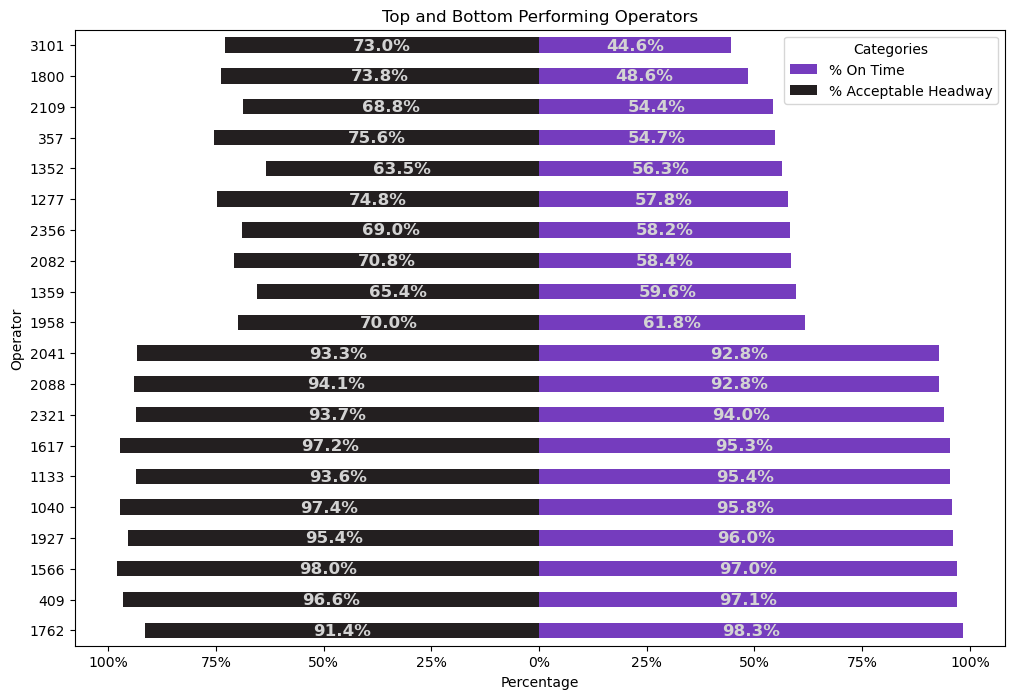

In [108]:
ax = top_bot_operators[['ONTIME_PCT', 'NEGATIVE_ACCEPTABLE']].plot(kind='barh',
                                                                      stacked=True,
                                                                      figsize=(12, 8),
                                                                     color= [purple,black])

ax.set(title = 'Top and Bottom Performing Operators',
        xlabel = 'Percentage',
       ylabel = 'Operator')

# set bar labels
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2, # horizontal alignment
      bar.get_height() + bar.get_y() - 0.41, # vertical alignment
      get_label_value(bar.get_width()), # value
      ha='center', # Center the labels
      color=gray,
      weight='bold',
      size=12
  )

ax.legend(bbox_to_anchor=(1, 1), title='Categories', labels = ['% On Time', '% Acceptable Headway'])
# Create custom percent labels
ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])

### Question 5: Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [101]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_BUNCHING',
       'HDWY_ACCEPTABLE', 'HDWY_GAPPING', 'LATE_EARLY', 'WEEKDAY', 'HOUR'],
      dtype='object')

In [102]:
wego['ADHERENCE']

0         -2.133333
1         -2.450000
2         -0.933333
3          6.283333
4         -1.583333
            ...    
350324    -8.433333
350325   -11.300000
350326    -4.316666
350327   -22.083333
350328   -23.666666
Name: ADHERENCE, Length: 350329, dtype: float64

In [103]:
wego_late = wego[wego['ADHERENCE'] <= -6]
wego_late

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,LATE_EARLY,WEEKDAY,HOUR
69,120230801,1,99457959,2023-08-01,22,2200,2374,345124,0,FROM DOWNTOWN,...,0,0.000000,NaN,NaN,0,0,0,late,1.0,15.0
78,120230801,1,99457968,2023-08-01,22,2200,2689,345127,0,TO DOWNTOWN,...,0,0.000000,NaN,39.027775,0,1,0,late,1.0,17.0
83,120230801,1,99457973,2023-08-01,22,2200,2689,345128,0,FROM DOWNTOWN,...,0,0.000000,NaN,8.129253,0,1,0,late,1.0,18.0
91,120230801,1,99457981,2023-08-01,22,2200,2689,345131,0,TO DOWNTOWN,...,0,22.000000,19.0,8.333332,0,1,0,late,1.0,19.0
92,120230801,1,99457982,2023-08-01,22,2200,2689,345131,0,TO DOWNTOWN,...,0,0.000000,NaN,23.266664,0,1,0,late,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406609,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,1.966666,5.0,16.388887,0,1,0,late,5.0,22.0
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.000000,NaN,17.555553,0,1,0,late,5.0,22.0
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.000000,NaN,NaN,0,0,0,late,5.0,22.0
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0,0.000000,NaN,58.333333,0,0,1,late,5.0,23.0


<Axes: xlabel='ADHERENCE', ylabel='HDWY_DEV'>

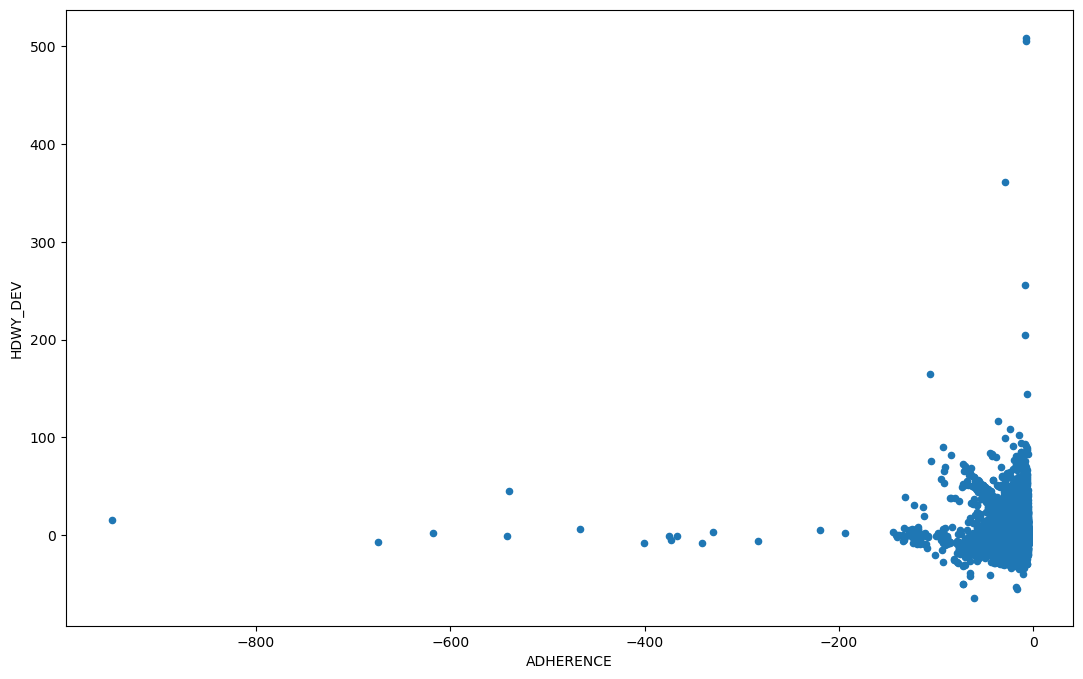

In [104]:
wego_late[['ADHERENCE', 'HDWY_DEV']].plot(x= 'ADHERENCE', y='HDWY_DEV',kind = 'scatter', figsize=(13,8))

<Axes: xlabel='ADHERENCE', ylabel='HDWY_DEV'>

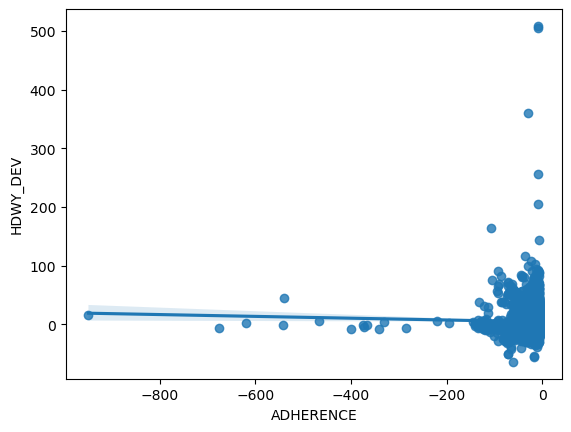

In [105]:
sns.regplot(x=wego_late['ADHERENCE'], y=wego_late['HDWY_DEV'])